In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM2D import TMCRBM2D
from TMCRBM import TMCRBM
from RBM import RBM
import gzip
import pickle
import functions
import h5py


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
f = gzip.open('../dataset/mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, _, _ = p
data = torch.as_tensor(train_set[0][:10000,:].T, device = device, dtype = dtype)


In [3]:
f_name_tmc = "../model/TMC2D/MNIST/AllParametersMNIST_TMC2DRBM_NGibbs50_Nmean20_Nh100_Nv784_Nmb500_Nepoch1000_lr_0.01_N20000_Npoint2500_Nchain10.h5"
f_tmc = h5py.File(f_name_tmc, "r")
alltimes = []
for t in f_tmc['alltime'][:]:
    if 'W'+str(t) in f_tmc:
        alltimes.append(t)
alltimes = np.array(alltimes)

In [1]:
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = torch.tensor(f_tmc['W0']).shape[0]
Nv = data.shape[0]
print(Nh)
ep_max = 100

RBM_TMC = TMCRBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)
_, _, V = torch.svd(RBM_TMC.W)

t = 2025
RBM_TMC.W = torch.tensor(f_tmc['W'+str(t)], device = RBM_TMC.device)
RBM_TMC.hbias = torch.tensor(f_tmc['hbias'+str(t)], device = RBM_TMC.device)
RBM_TMC.vbias = torch.tensor(f_tmc['vbias'+str(t)], device = RBM_TMC.device)
_, S_tmc, V_tmc = torch.svd(RBM_TMC.W)

NameError: name 'torch' is not defined

In [5]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 200 # Nb it_mcmc pour chaque chaine
it_mean = 100 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 15000 # Nb de points de discrétisation pour w_hat
proj_data =torch.mm(data.T, V_tmc).cpu()/RBM_TMC.Nv**0.5
xmin = torch.min(proj_data[:,0])-0.2
xmax = torch.max(proj_data[:,0])+0.2
border_length=0.1


In [57]:
p_m, grad_pot, potential, w_hat_b = functions.ComputeProbabilityTMC1D(RBM_TMC, data.T, nb_chain, it_mcmc, it_mean, N, nb_point, border_length, device)

w_hat_b = w_hat_b.cpu()
p_m = p_m.cpu()

In [40]:
gen_data = functions.SampleTMC1D(p_m, w_hat_b, 1000)
gen_data = gen_data.cpu().numpy()

In [7]:
vinit = torch.bernoulli(torch.rand(
        (RBM_TMC.Nv, 10000), device=RBM_TMC.device, dtype=RBM_TMC.dtype))

si, mi, _, _ = RBM_TMC.Sampling(vinit, it_mcmc=10000)
proj_gen = torch.mm(si.T, V).cpu().numpy()/RBM_TMC.Nv**.5

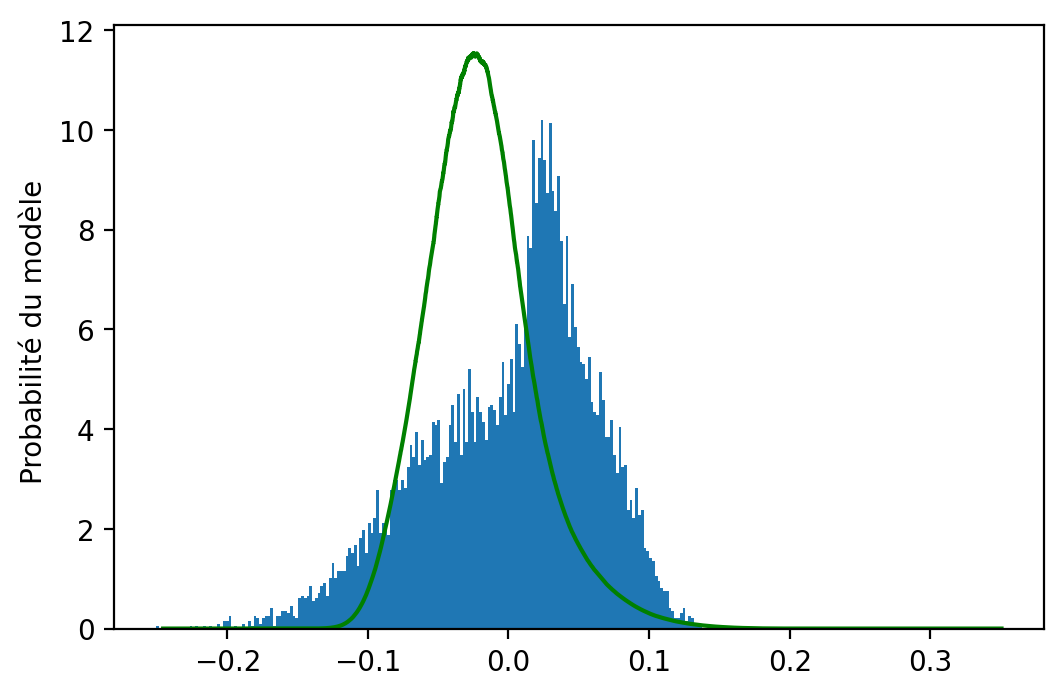

In [52]:
plt.figure(dpi=200)
plt.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200)
#plt.hist(gen_data, bins = 200, density=True)
#plt.hist(proj_gen[:,0], label = 'données générées', density=True, bins=200)
plt.plot(w_hat_b[1:], p_m, color = "green", label = "probabilité du modèle")
plt.ylabel("Probabilité du modèle ")
plt.legend
plt.show()

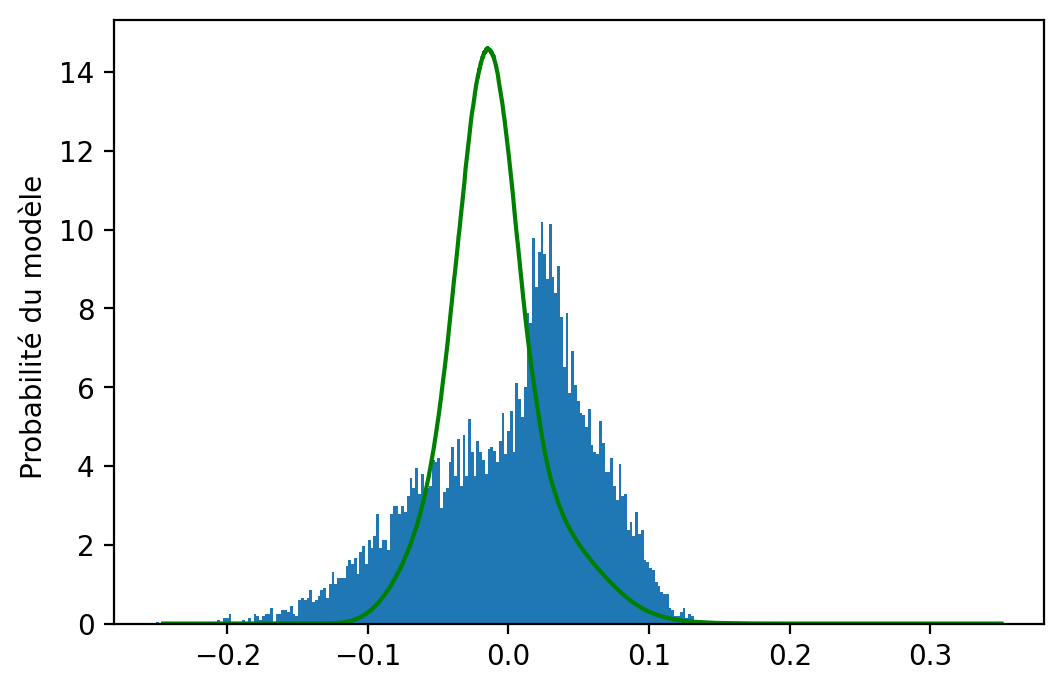

In [55]:
plt.figure(dpi=200)
plt.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200)
#plt.hist(gen_data, bins = 200, density=True)
#plt.hist(proj_gen[:,0], label = 'données générées', density=True, bins=200)
plt.plot(w_hat_b[1:], p_m, color = "green", label = "probabilité du modèle")
plt.ylabel("Probabilité du modèle ")
plt.legend
plt.show()

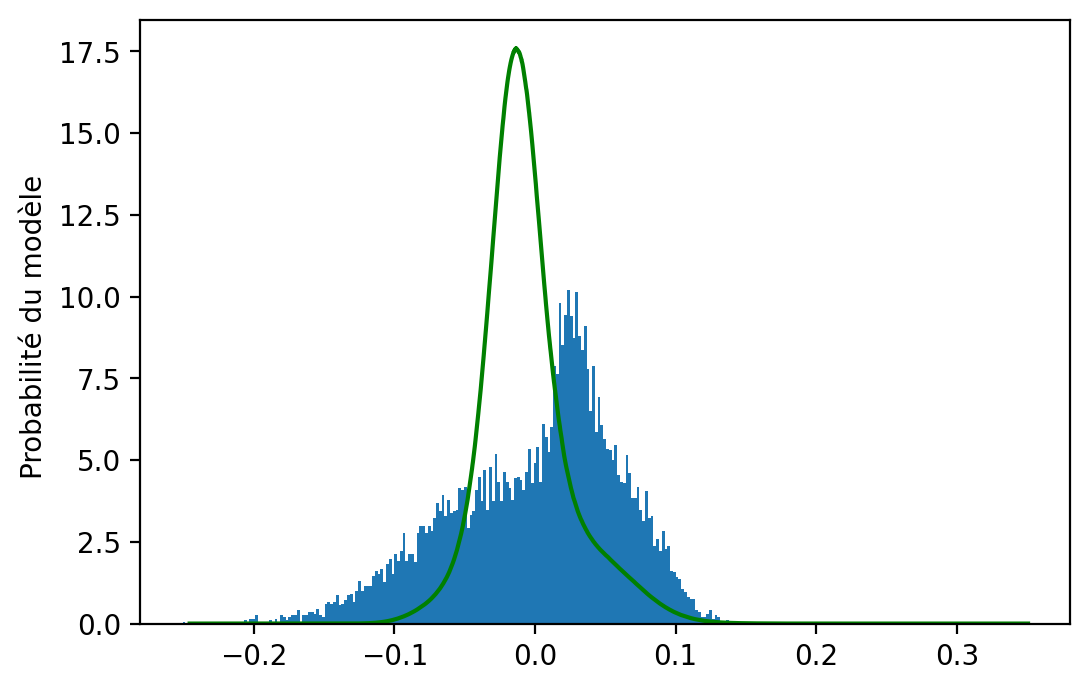

In [58]:
plt.figure(dpi=200)
plt.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200)
#plt.hist(gen_data, bins = 200, density=True)
#plt.hist(proj_gen[:,0], label = 'données générées', density=True, bins=200)
plt.plot(w_hat_b[1:], p_m, color = "green", label = "probabilité du modèle")
plt.ylabel("Probabilité du modèle ")
plt.legend
plt.show()

In [13]:
times_gen_tmc = np.array([110,783,2025,5208,13138])
all_mi_tmc = []
for t in times_gen_tmc:
    print(t)
    RBM_TMC.W = torch.tensor(f_tmc['W'+str(t)], device = RBM_TMC.device)
    RBM_TMC.vbias = torch.tensor(f_tmc['vbias'+str(t)], device = RBM_TMC.device)
    RBM_TMC.hbias = torch.tensor(f_tmc['hbias'+str(t)], device = RBM_TMC.device)
    _, S_tmc, V_tmc = torch.svd(RBM_TMC.W)
    p_m, _, _, w_hat_b = functions.ComputeProbabilityTMC1D(RBM_TMC, data.T, nb_chain, 50, 20, N, nb_point, border_length, device)
    si, mi = functions.genDataTMC1D(RBM_TMC, p_m, w_hat_b, 100, N, V_tmc, it_mcmc=30)
    all_mi_tmc.append(mi)

110
783
2025
5208
13138


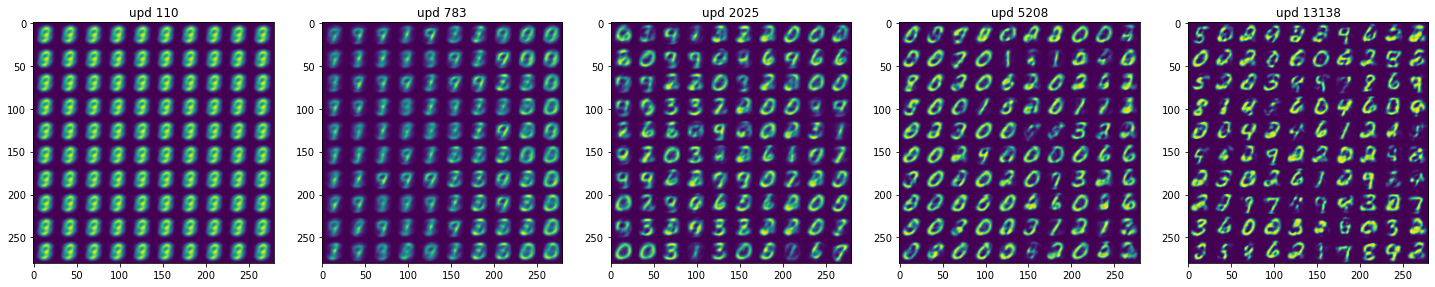

In [14]:
fig,ax = plt.subplots(1,len(times_gen_tmc),figsize=(25,10))
for idx in range(len(times_gen_tmc)):
    Im = RBM_TMC.ImConcat(all_mi_tmc[idx].t(),sx=28,sy=28,ncol=10,nrow=10,ch=1)
    ax[idx].imshow(Im.cpu())
    ax[idx].set_title("upd "+str(times_gen_tmc[idx]))


In [6]:
f_name_rdm = "../model/AllParametersLongRUNExMC_MNIST_Nh500_lr0.01_l20.0_NGibbs100.h5"

f_rdm = h5py.File(f_name_rdm, "r")
alltimes = []
for t in f_rdm['alltime'][:]:
    if 'paramW'+str(t) in f_rdm:
        alltimes.append(t)
alltimes = np.array(alltimes)
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = torch.tensor(f_rdm['paramW0']).shape[0]
Nv = data.shape[0]
print(Nh)
ep_max = 100


RBM_RDM = TMCRBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

_, S_rdm, V_rdm = torch.svd(RBM_TMC.W)

500


In [16]:
times_gen_rdm=[128,768,2048,5120,12288]
all_mi_rdm = []
for t in times_gen_rdm:
    print(t)
    RBM_RDM.W = torch.tensor(f_rdm['paramW'+str(t)], device = RBM_RDM.device)
    _, S_rdm, V_rdm = torch.svd(RBM_RDM.W)
    RBM_RDM.vbias = torch.tensor(f_rdm['paramVB'+str(t)], device = RBM_RDM.device)
    RBM_RDM.hbias = torch.tensor(f_rdm['paramHB'+str(t)], device = RBM_RDM.device)
    p_m, _, _, w_hat_b = functions.ComputeProbabilityTMC1D(RBM_RDM, data.T, nb_chain, 50, 20, N, nb_point, border_length, device)
    si, mi = functions.genDataTMC1D(RBM_RDM, p_m, w_hat_b, 100, N, V_rdm, it_mcmc=30)
    all_mi_rdm.append(mi)

128
768
2048
5120
12288


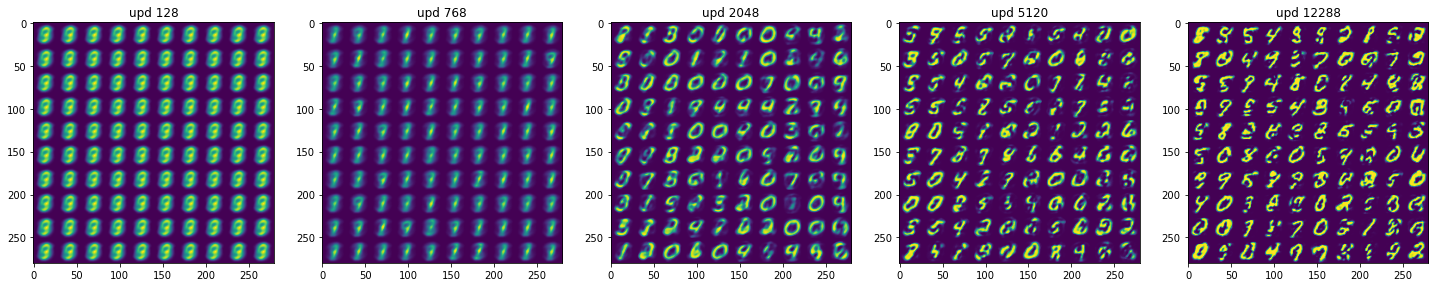

In [17]:
fig,ax = plt.subplots(1,len(all_mi_rdm),figsize=(25,10))
for idx in range(len(all_mi_rdm)):
    Im = RBM_RDM.ImConcat(all_mi_rdm[idx].t(),sx=28,sy=28,ncol=10,nrow=10,ch=1)
    ax[idx].imshow(Im.cpu())
    ax[idx].set_title("upd "+str(times_gen_rdm[idx]))


In [ ]:
Im1 = RBM_RDM.ImConcat(all_mi_rdm[-1].t(),sx=28,sy=28,ncol=10,nrow=10,ch=1)
Im1 = RBM_RDM.ImConcat(all_mi_rdm[-1].t(),sx=28,sy=28,ncol=10,nrow=10,ch=1)

plt.imshow()

In [7]:
t=13138
RBM_TMC.W = torch.tensor(f_tmc['W'+str(t)], device = RBM_RDM.device)
_, S_tmc, V_tmc = torch.svd(RBM_TMC.W)
RBM_TMC.vbias = torch.tensor(f_tmc['vbias'+str(t)], device = RBM_RDM.device)
RBM_TMC.hbias = torch.tensor(f_tmc['hbias'+str(t)], device = RBM_RDM.device)
vinit = torch.bernoulli(torch.rand(
    (RBM_TMC.Nv, 1000), device=RBM_RDM.device, dtype=RBM_RDM.dtype))
si,mi,_,_ = RBM_TMC.Sampling(vinit,it_mcmc=10000)

In [99]:
proj_gen_x = torch.mm(si.T, V_tmc)/RBM_TMC.Nv**.5
proj_data = torch.mm(data.T, V_tmc)/RBM_TMC.Nv**.5

In [87]:
p_m_2, _, _, w_hat_b_2 = functions.ComputeProbabilityTMC1D(RBM_TMC, data.T, nb_chain, 500, 250, N, nb_point, border_length, V_tmc, device)

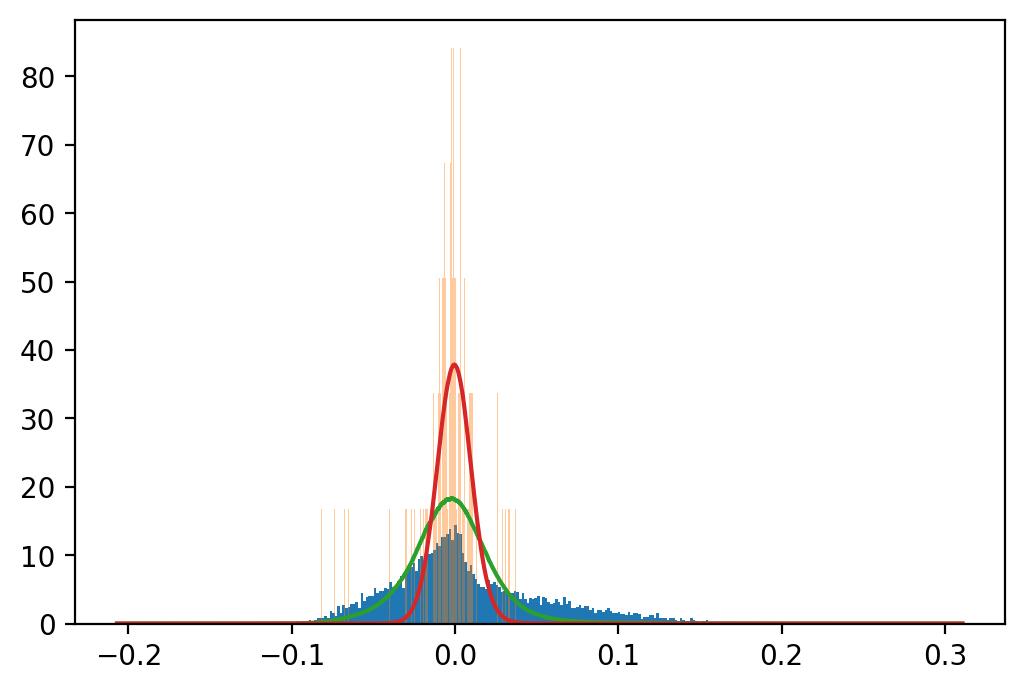

In [100]:
plt.figure(dpi=200)
plt.hist(proj_data[:,0].cpu().numpy(), bins =200, density=True);
plt.hist(proj_gen_x[:,0].cpu().numpy(), bins=200, density=True, alpha = 0.4);
plt.plot(w_hat_b.cpu()[1:], p_m.cpu())
plt.plot(w_hat_b_2.cpu()[1:], p_m_2.cpu())

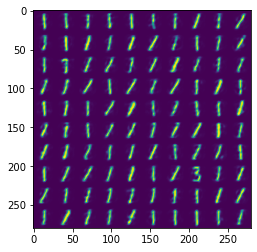

In [94]:
IM = RBM_TMC.ImConcat(mi.t(),sx=28,sy=28,ncol=10,nrow=10,ch=1)
plt.imshow(IM.cpu())

In [97]:
si, mi = functions.genDataTMC1D(RBM_TMC, p_m, w_hat_b, 100, N, V_tmc, it_mcmc=500)


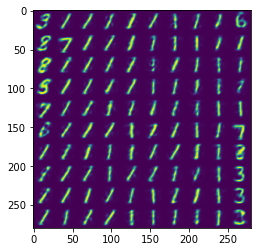

In [98]:
IM50 = RBM_TMC.ImConcat(mi.t(),sx=28,sy=28,ncol=10,nrow=10,ch=1)
plt.imshow(IM50.cpu())

In [10]:
p_m_3, _, _, w_hat_b_3 = functions.ComputeProbabilityTMC1D(RBM_TMC, data.T, nb_chain, 500, 250, N, nb_point, border_length, V_data, device)

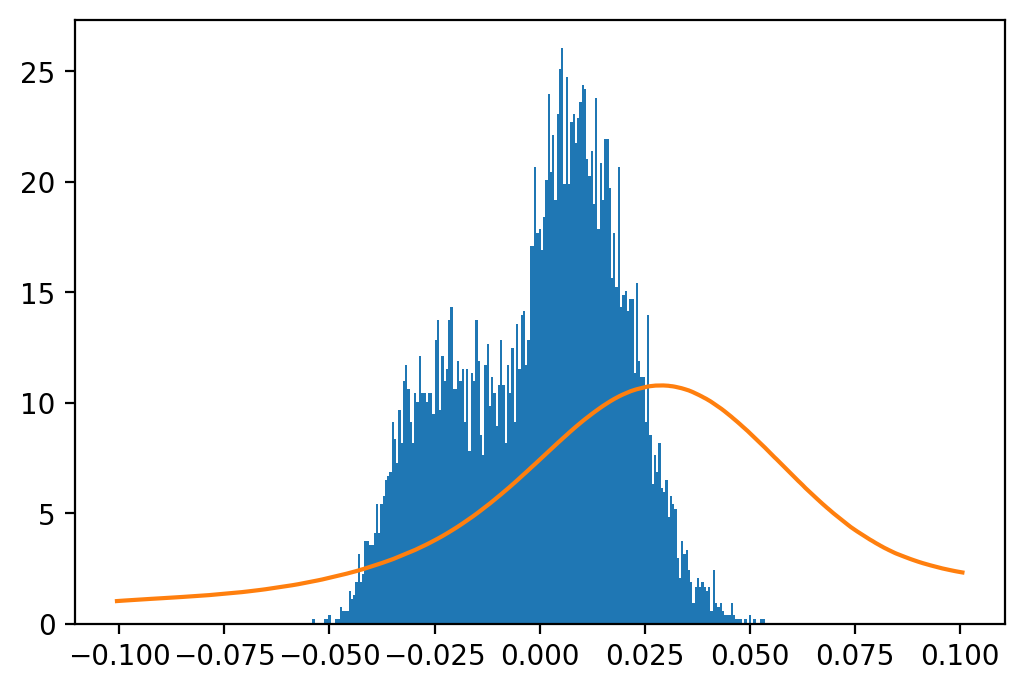

In [12]:
plt.figure(dpi=200)
plt.hist(pca_data[:,2].cpu().numpy(), bins =200, density=True);
#plt.hist(proj_gen_x[:,0].cpu().numpy(), bins=200, density=True, alpha = 0.4);
#plt.plot(w_hat_b.cpu()[1:], p_m.cpu())
plt.plot(w_hat_b_3.cpu()[1:], p_m_3.cpu())

In [ ]:
heatmap_data, xedges_data, yedges_data = np.histogram2d(proj_data[:,0].numpy(), proj_data[:,1].numpy(), bins=50)
heatmap_gen, xedges_gen, yedges_gen = np.histogram2d(proj_gen[:,0], proj_gen[:,1], bins=50)

In [ ]:
extent = [xedges_data[0], xedges_data[-1], yedges_data[0], yedges_data[-1]]

plt.clf()
plt.imshow(heatmap_data.T, extent=extent, origin='lower')
plt.contour(heatmap_gen.T, extent = extent,  cmap='RdBu_r')

In [ ]:
extent = [xedges_gen[0], xedges_gen[-1], yedges_gen[0], yedges_gen[-1]]

plt.clf()
plt.imshow(heatmap_gen.T, extent=extent, origin='lower')


In [ ]:
plt.imshow(V[:,0].reshape(28,28).cpu())

In [33]:
proj_gen_x = torch.mm(si.T, V_).cpu().numpy()

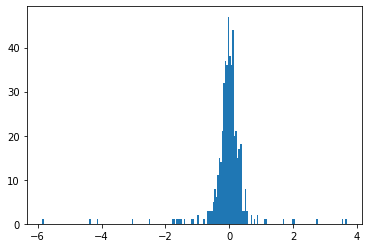

In [36]:

plt.hist(proj_gen_x[0,:], bins=200);

In [30]:
V_rdm.shape

torch.Size([784, 500])

In [109]:
data.shape

torch.Size([784, 10000])

In [8]:
_,S_data,V_data = torch.svd(data.T)

In [9]:
pca_data = torch.mm(data.T, V_data)/data.shape[1]**.5

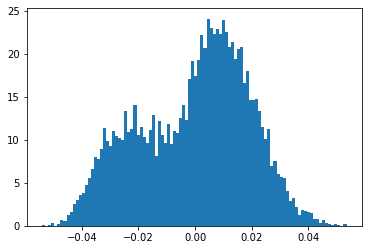

In [134]:
plt.hist(pca_data[:,2].cpu().numpy(), bins=100, density=True);

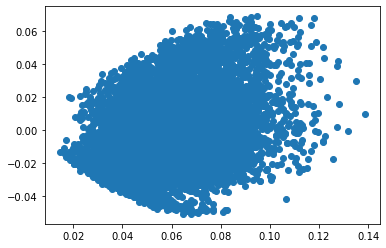

In [116]:
plt.scatter(pca_data[:,0].cpu(),pca_data[:,1].cpu())

In [126]:
heatmap_data, xedges_data, yedges_data = np.histogram2d(pca_data[:,1].cpu().numpy(), pca_data[:,2].cpu().numpy(), bins=50)

extent = [xedges_data[0], xedges_data[-1], yedges_data[0], yedges_data[-1]]


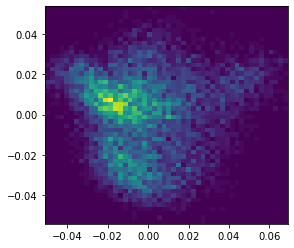

In [127]:
plt.clf()
plt.imshow(heatmap_data.T, extent=extent, origin='lower')